In [49]:
import os
import sys

import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

np.random.seed(42)
C0 = '#005AFF'
C1 = '#FF4B00'

if "../scripts" not in sys.path:
    sys.path.append("../scripts")
    
plt.rcParams["font.size"] = 18
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare the data by solve Rossler equation

In [50]:
from scipy.integrate import solve_ivp
dim_x = 3 
mu = 1e0
epoch = 50
N = 500
T = 80
delta_t = T / N

a_param = 0.2
b_param = 0.2
c_param = 2.5

def exponential_decay(t, y):
    y0 = - y[1] - y[2]
    y1 = y[0] + a_param * y[1]
    y2 = b_param + y[0] * y[2] - c_param * y[2]
    return np.asarray([y0, y1, y2])

data = []
times = []
for i in range(epoch):
    x0 = np.random.randn(dim_x) * 1

    t = np.arange(N) * delta_t
    sol = solve_ivp(exponential_decay, [0, T], y0=x0, t_eval=t)
    if sol.success:
        data.append(sol.y.T)
        times.append(sol.t.reshape(-1, 1))
    else:
        print("failure", x0)
        
data = np.stack(data, axis=0)
times = np.stack(times, axis=0)

# Auto Correlation analysis and FFT to identify the latent exponent parameter.

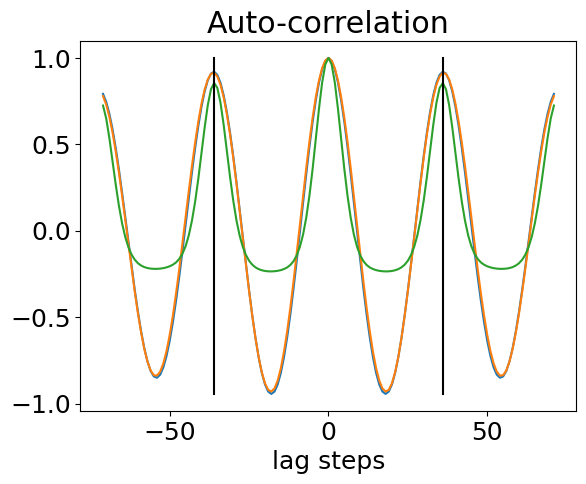

steps:36, period 5.76(s), freq: 0.17Hz


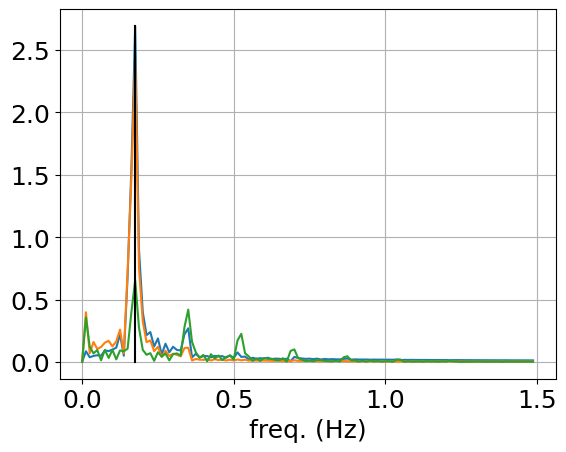

time exponent range [0.62831853 3.14159265] rad/s


In [51]:
from scipy.fft import fft, fftfreq
import scipy
from scipy.signal.windows import blackman

X = data[0]
X = X - X.mean(axis=0)
time = times[0].ravel()
dt = np.diff(time, axis=0).mean()

result = np.stack([scipy.signal.correlate(X[:, i], X[:, i], mode='full') for i in range(dim_x)], axis=-1)
result = result / result.max(axis=0)
lags = scipy.signal.correlation_lags(len(X), len(X))
steps = 36
natural_freq = 1 / (steps * dt)

index = np.abs(lags) < steps * 2
plt.plot(lags[index], result[index])
plt.plot(steps * np.ones(10), np.linspace(result.min(), result.max(), 10), "black")
plt.plot(-steps * np.ones(10), np.linspace(result.min(), result.max(), 10), "black")
plt.xlabel("lag steps")
plt.title("Auto-correlation")
plt.show()
print(f"steps:{steps}, period{steps * dt:5.2f}(s), freq:{natural_freq:5.2f}Hz")

# Number of sample points
N = len(X)
# sample spacing

x = np.arange(N) * dt
yf = fft(X[:, :], axis=0)
xf = fftfreq(N, dt)[:N//2]
norm = 2.0/ N * np.abs(yf[:N//2])
max_plot_freq = xf < 1.5  # Hz
plt.plot(xf[max_plot_freq], norm[max_plot_freq])
plt.plot(np.ones(10)  / (steps * dt), np.linspace(norm.min(), norm.max(), 10), "black")
plt.grid()
plt.xlabel("freq. (Hz)")
plt.show()
amplitude_range = 2 * np.pi * np.array([0.1, 0.5])
print("time exponent range", amplitude_range, "rad/s")

# Learning

In [52]:
trajectory = torch.tensor(data, dtype=torch.float32, device="cuda")
trajectory = trajectory.cuda()
dt = np.diff(times, axis=1).mean()

print("traj.shape", trajectory.shape, "dt", dt)

traj.shape torch.Size([50, 500, 3]) dt 0.16000000000000003


In [53]:
from phase_amplitude_reduction import PADynTrainer


dim_obs = trajectory.shape[-1]
recon_loss_coef = torch.ones(dim_obs, dtype=trajectory.dtype, device=trajectory.device) * 1.0

trainer = PADynTrainer(
    dim_latent=3,
    dim_obs=dim_obs,
    hidden_layer_size=[512, 512],
    delta_t=dt,
    device="cuda",
    num_iters=5000,
    learning_rate=1e-3,
    discount_gamma=0.999,  # 0.99 ** 50 ~ 0.6
    latent_noise=1e-5,
    natural_freq=natural_freq,
    amplitude_range=amplitude_range,
    recon_loss_coef=recon_loss_coef
)

In [54]:
# trainer.learn(trajectory[:trajectory.shape[0] // 2, :trajectory.shape[1] // 2])
# trainer.save("../data/rossler-model.pt")
model = trainer.load("../data/rossler-model.pt")
model.to("cuda")
trainer =  model

Text(0.5, 0, 'iteration')

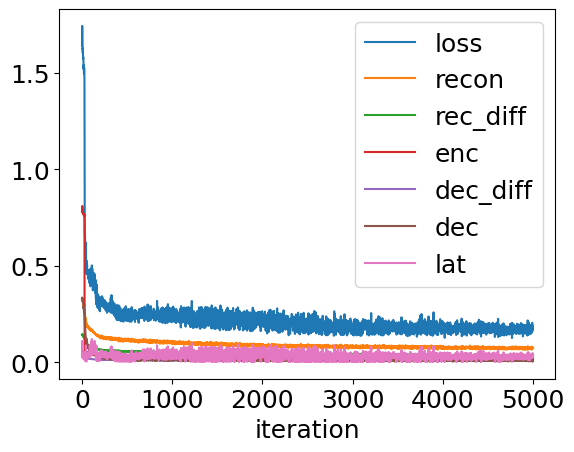

In [55]:
loss = np.array([x.detach().cpu() for x in trainer.record["loss"]])
loss_recon = np.array([x.detach().cpu() for x in trainer.record["loss_recon"]])
loss_rec_diff = np.array([x.detach().cpu() for x in trainer.record["loss_rec_diff"]])
loss_enc = np.array([x.detach().cpu() for x in trainer.record["loss_enc"]])
loss_dec_diff = np.array([x.detach().cpu() for x in trainer.record["loss_dec_diff"]])
loss_dec = np.array([x.detach().cpu() for x in trainer.record["loss_dec"]])
loss_lat = np.array([x.detach().cpu() for x in trainer.record["loss_lat"]])
plt.plot(loss, label="loss")
plt.plot(loss_recon, label="recon")
plt.plot(loss_rec_diff, label="rec_diff")
plt.plot(loss_enc, label="enc")
plt.plot(loss_dec_diff, label="dec_diff")
plt.plot(loss_dec, label="dec")
plt.plot(loss_lat, label="lat")
plt.legend()
plt.xlabel("iteration")

In [56]:
T = data.shape[1]
traj = torch.tensor(data, dtype=torch.float32, device="cuda")
obs_pred, latent = trainer.rollout(traj[:, 0:1], T, predict=True)
latent = latent.detach().cpu()
obs_pred = obs_pred.detach().cpu().numpy()

with torch.no_grad():
    latent_enc = trainer.enc(traj)
    obs_rec= trainer.dec(latent_enc)
    obs_rec = obs_rec.detach().cpu().numpy()
    latent_enc = latent_enc.detach().cpu().numpy()

In [57]:
print("data shape:", obs_pred.shape, data.shape)
print("train size:{}, test size:{}".format(data.shape[0] // 2, data.shape[0] // 2))
num_data = data.shape[0]
norm = np.square(obs_pred[num_data // 2:] - data[num_data // 2:]).sum(axis=2)
RMSE = np.sqrt(norm.mean(axis=1)).mean(axis=0)
print(f"test RMSE:{RMSE:.5f}")

data shape: (50, 500, 3) (50, 500, 3)
train size:25, test size:25
test RMSE:1.03275


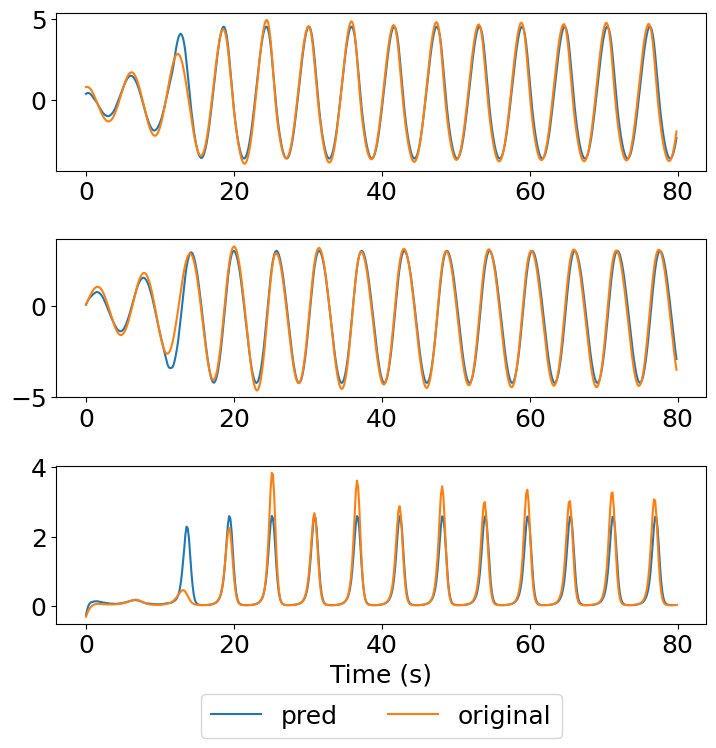

In [58]:
plt.figure(figsize=(7.5, 8))
idx = num_data //2
for i in range(data.shape[-1]):
    plt.subplot(3, 1, i + 1)
    plt.plot(times[idx], obs_pred[idx, :, i], label="pred")
    plt.plot(times[idx], data[idx, :, i], label="original")
plt.xlabel("Time (s)")
plt.legend(bbox_to_anchor=(0.5, -.8), loc="lower center", ncol=2)
plt.tight_layout()
plt.show()

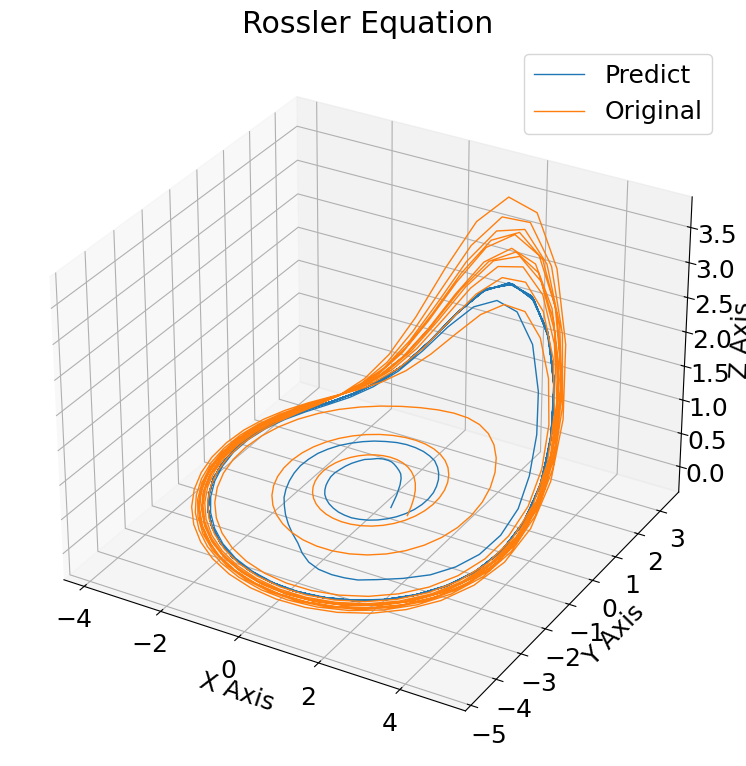

In [59]:
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

ax.plot(*obs_pred[idx].T, lw=1.0, label="Predict")
ax.plot(*data[idx].T, lw=1.0, label="Original")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Rossler Equation")
plt.legend()
plt.tight_layout()
plt.show()